In [8]:
import os
import tarfile
import urllib

DL_ROOT = 'https://raw.githubusercontent.com/ageron/handson-ml2/master/'
HOUSING_PATH = os.path.join('datasets','housing')
HOUSING_URL = DL_ROOT + 'datasets/housing/housing.tgz'

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, 'housing.tgz')
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

fetch_housing_data()
!pwd

/home/matt/portfolio/practice_projects/notebooks


In [10]:
import pandas as pd

housing = pd.read_csv('datasets/housing/housing.csv')

In [11]:
# housing EDA

# 20640 entries, 10 features
# 207 missing values for total bedrooms
# total rooms and total bedrooms seems to have a mix of count and square footage
# all numeric except ocean_proximity
    # 

housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


array([[<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'housing_median_age'}>],
       [<AxesSubplot:title={'center':'total_rooms'}>,
        <AxesSubplot:title={'center':'total_bedrooms'}>,
        <AxesSubplot:title={'center':'population'}>],
       [<AxesSubplot:title={'center':'households'}>,
        <AxesSubplot:title={'center':'median_income'}>,
        <AxesSubplot:title={'center':'median_house_value'}>]],
      dtype=object)

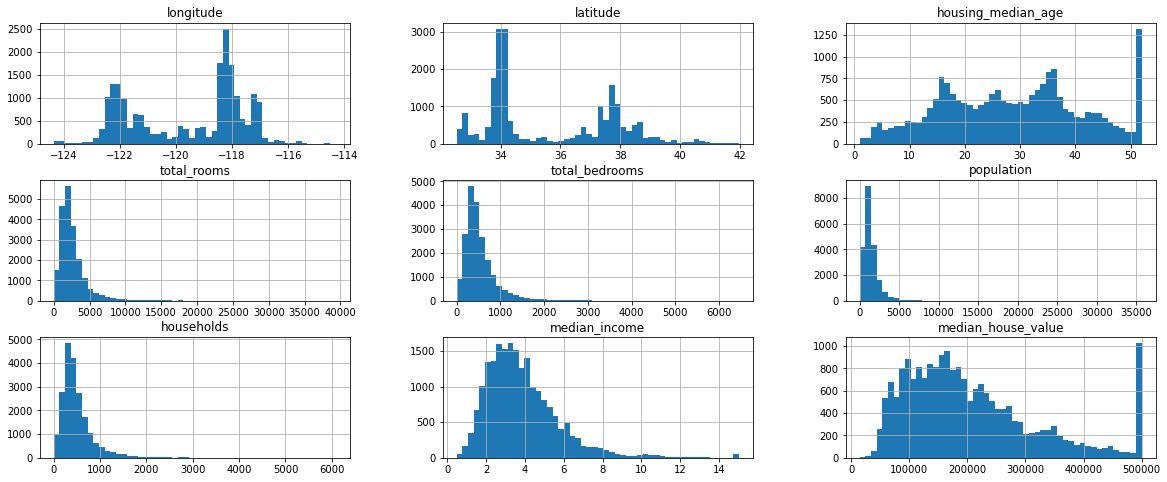

In [24]:
import matplotlib.pyplot as plt

housing.hist(bins=50, figsize=[20,8])

In [ ]:
# housing_median_age and median_housing_value are clearly capped
    # median_income too, but not as badly
    # capped median_housing_value would be a big problem if we want our model to accurately predict values >500k
# median_income is a transformed value, roughly 1 = $10k
# many features are heavily positive/right skewed, and therefore may benefit from a transformation

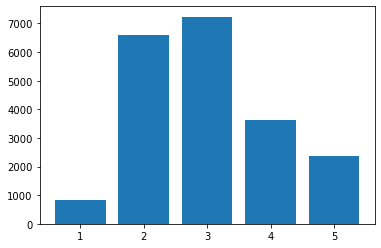

In [49]:
# normal train test split procedure:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size = 0.2)

# however, we know that the median_income is a vital feature for accurate prediction
# therefore it will pay off to stratifiy our split on median_income

import numpy as np

housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

fig, ax = plt.subplots()
ax.bar(housing['income_cat'].value_counts().index, housing['income_cat'].value_counts().values)

from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in sss.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [62]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.039826,0.039729,0.043120,8.272506,-0.243309
2,0.318847,0.318798,0.322190,1.048473,-0.015195
3,0.350581,0.350533,0.338421,-3.468767,-0.013820
4,0.176308,0.176357,0.181928,3.187689,0.027480
5,0.114438,0.114583,0.114341,-0.084674,0.127011


In [66]:
# disparity in proprotions for stratified vs random error is substantial

# for set_ in (strat_train_set, strat_test_set):
#     set_.drop(columns = 'income_cat', inplace = True)

housing = strat_train_set.copy()

Text(0.5, 1.0, 'Population and Income for California Housing Districts')

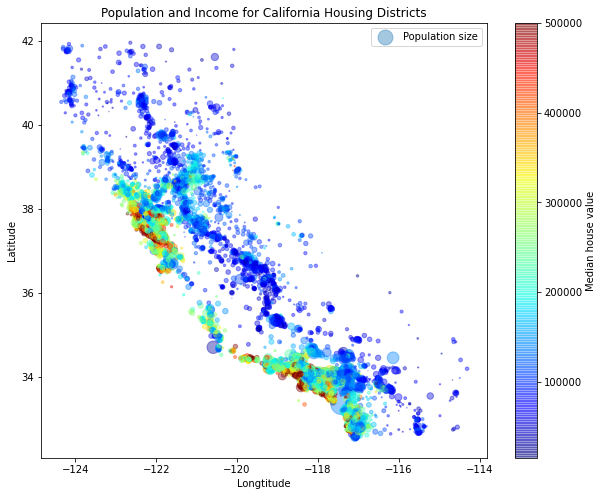

In [119]:
fig, ax = plt.subplots(figsize = [10,8])
sc = ax.scatter(housing['longitude'], housing['latitude'], alpha=0.4, 
    s = housing['population'] / 80,
    label='Population size',
    c = housing['median_house_value'],
    cmap = 'jet',)
plt.colorbar(sc, label = 'Median house value')
ax.set_ylabel('Latitude')
ax.set_xlabel('Longtitude')
ax.legend()
ax.set_title('Population and Income for California Housing Districts')

# housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
#              s=housing["population"]/100, label="population", figsize=(10,7),
#              c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
#              sharex=False)
# plt.legend()
# save_fig("housing_prices_scatterplot")

In [137]:
corr_matrix = housing.corr()
corr_matrix['median_house_value']

longitude            -0.047432
latitude             -0.142724
housing_median_age    0.114110
total_rooms           0.135097
total_bedrooms        0.047689
population           -0.026920
households            0.064506
median_income         0.687160
median_house_value    1.000000
Name: median_house_value, dtype: float64

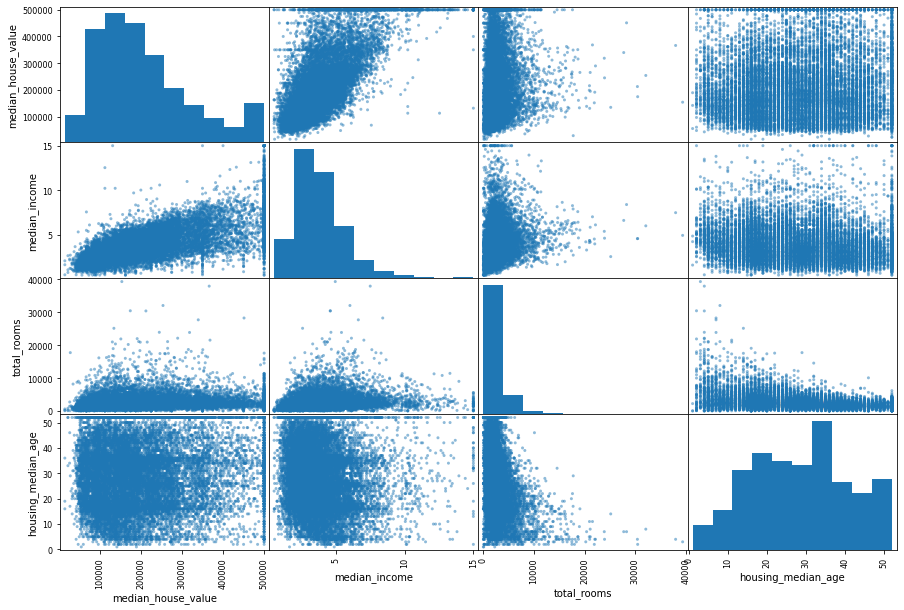

In [135]:
from pandas.plotting import scatter_matrix

features = ['median_house_value','median_income','total_rooms','housing_median_age']

scatter_matrix(housing[features], figsize = [15,10]);